In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees


# Load Model

In [11]:
query_type = 'far'

In [12]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "darkroom_simple"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd256_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0.0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed0_batch1024"

model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)
eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{wandb_project}/{env_name}/datasets/eval.pkl"

epoch=8-val_loss=0.857135.ckpt


In [13]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [14]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_2054271/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [15]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [16]:
from src.envs.darkroom import DarkroomEnv

i_eval = 3
traj = eval_trajs[i_eval]
env_config = {
    'maze_dim': maze_dim,
    'horizon': 200,
    'state_dim': state_dim,
    'node_encoding_corr': node_encoding_corr,
    'initialization_seed': np.array(traj['initialization_seed']).item(),
    'goal': np.array(traj['goal'])
}
env = DarkroomEnv(**env_config)
optimal_action_map, dist_from_goal = env.make_opt_action_dict()
valid_query_states = []
for i in range(len(traj['context_states'])):
    d = dist_from_goal[tuple(traj['context_states'][i].tolist())]
    if query_type == 'far' and d < 7:
        continue
    elif query_type == 'middle' and d != 5:
       continue
    valid_query_states.append(traj['context_states'][i])
if len(valid_query_states) == 0:
    print('No valid query states found')
else:
    traj['query_state'] = valid_query_states[np.random.choice(len(valid_query_states))]


In [17]:
for seq_length in [50, 100, 150]:
    print(f'Context length: {seq_length}, Reward: {traj['context_rewards'][:seq_length].sum()}')

first_reward_idx = np.where(traj['context_rewards'] != 0)[0][0]
print(f'First nonzero reward at step {first_reward_idx}: {traj['context_rewards'][first_reward_idx]}')


Context length: 50, Reward: 1
Context length: 100, Reward: 1
Context length: 150, Reward: 5
First nonzero reward at step 16: 1


In [18]:
context_length = 125

# Run Gradient Attribution

In [19]:
def format_transformer_input_from_batch(batch, model):
    query_states = batch['query_states'][:, None, :]
    zeros = batch['zeros'][:, None, :]
    state_seq = torch.cat([batch['context_states'], query_states], dim=1)
    action_seq = torch.cat(
        [batch['context_actions'], zeros[:, :, :model.action_dim]], dim=1)
    next_state_seq = torch.cat(
        [batch['context_next_states'], zeros[:, :, :model.state_dim]], dim=1)
    reward_seq = torch.cat([batch['context_rewards'], zeros[:, :, :1]], dim=1)
    seq = torch.cat(
        [state_seq, action_seq, next_state_seq, reward_seq], dim=2)
    seq_len = seq.shape[1]
    stacked_inputs = model.embed_transition(seq)
    return stacked_inputs

In [20]:
def format_batches(traj):
    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'][:context_length])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'][:context_length])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'][:context_length])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'][:context_length])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),
        } 
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k]
        batch[k] = batch[k].to(model.device)
    baseline_batch = {}
    for k, v in batch.items():
        baseline_batch[k] = v.clone() if isinstance(v, torch.Tensor) else v
    baseline_batch['context_actions'] *= 0
    #baseline_batch['context_actions'] += 0.25
    return baseline_batch, batch

In [21]:
baseline_batch, batch = format_batches(traj)

In [22]:
layer_outputs = {}
hooks = []

def get_hook(layer_name):
    def hook(module, input, output):
        layer_outputs[layer_name] = output
    return hook

for attn_layer, module in enumerate(model.transformer.h):
    module.register_forward_hook(get_hook(attn_layer))

In [23]:
traj['optimal_action'].argmax()

np.int64(3)

In [24]:
with torch.no_grad():
    final_output = model(batch)
    prediction = final_output[:, traj['optimal_action'].argmax()]

In [25]:
# Calculate attributions for each layer
layer_attributions = {}
inputs = format_transformer_input_from_batch(batch, model)
baseline_inputs = format_transformer_input_from_batch(baseline_batch, model)

for layer_name, layer_output in layer_outputs.items():
    # Prepare interpolated inputs
    alphas = torch.linspace(0, 1, steps=20)
    
    all_grads = []
    for alpha in alphas:
        interp_input = alpha*inputs + (1-alpha)*baseline_inputs
        interp_input.requires_grad_(True)
        
        # Forward pass to get layer output
        transformer_output = model.transformer(inputs_embeds=interp_input)
        preds = model.pred_actions(transformer_output['last_hidden_state'])
        preds = preds[:, -1, :]
        target = preds[:, traj['optimal_action'].argmax()]
        current_layer_output = layer_outputs[layer_name][0]

        grad_wrt_layer = torch.autograd.grad(
           outputs=target,
           inputs=current_layer_output,
           grad_outputs=torch.ones_like(target),
           retain_graph=True
        )[0]
        
        grad_wrt_input = torch.autograd.grad(
            outputs=current_layer_output[:, -1],
            inputs=interp_input,
            grad_outputs=current_layer_output[:, -1],
            retain_graph=True
        )[0]
        
        all_grads.append(grad_wrt_input)
    
    # Average gradients and compute attribution
    avg_grad = torch.stack(all_grads).mean(dim=0)
    avg_grad = avg_grad.detach().cpu().numpy().squeeze()
    delta_input = (inputs - baseline_inputs).detach().cpu().numpy().squeeze()
    attribution = np.sum(avg_grad * delta_input, axis=1)
    layer_attributions[layer_name] = attribution

# Output w.r.t Input
alphas = torch.linspace(0, 1, steps=20)
all_grads = []
for alpha in alphas:
    interp_input = alpha*inputs + (1-alpha)*baseline_inputs
    interp_input.requires_grad_(True)
    
    # Forward pass to get layer output
    transformer_output = model.transformer(inputs_embeds=interp_input)
    preds = model.pred_actions(transformer_output['last_hidden_state'])
    preds = preds[:, -1, :]
    target = preds[:, traj['optimal_action'].argmax()]
    current_layer_output = layer_outputs[layer_name][0]

    grad_wrt_input = torch.autograd.grad(
        outputs=target,
        inputs=interp_input,
        grad_outputs=target,
        retain_graph=True
    )[0]
    all_grads.append(grad_wrt_input)
avg_grad = torch.stack(all_grads).mean(dim=0)
avg_grad = avg_grad.detach().cpu().numpy().squeeze()
delta_input = (inputs - baseline_inputs).detach().cpu().numpy().squeeze()
input_to_output_attribution = np.sum(avg_grad * delta_input, axis=1)

# Visualize

In [33]:
from copy import copy
import networkx as nx

def plot_trajectory(
        states, next_states, query_state, attentions, env, figname=None):
    
    G = env.to_networkx()
    pos = {node: node for node in G.nodes()}

    fig, ax = plt.subplots(figsize=(4,4))  # Create a new figure
    nx.draw(G, pos,
           node_color='lightblue',
           edge_color='white',
           node_size=100,
           font_size=8,
           font_weight='bold',
           width=1,
           alpha=1.)


    goal_state = env.node_map_encoding_to_pos[tuple(env.goal.tolist())]
    query_state = env.node_map_encoding_to_pos[tuple(query_state.tolist())]
    # Then draw specific nodes in green
    nx.draw_networkx_nodes(G, pos,
                      nodelist=[query_state],
                      node_color='green',
                      node_size=100)
    nx.draw_networkx_nodes(G, pos,
                      nodelist=[goal_state],
                      node_color='green',
                      node_size=100,
                      node_shape='*')
    
    for state, next_state, attention in zip(states, next_states, attentions):
        edge_color = 'red' if attention > 0 else 'blue'
        nx.draw_networkx_edges(G, pos,
            edgelist=[(tuple(state), tuple(next_state))],
            edge_color=edge_color,
            alpha=abs(attention),
            width=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    if figname is not None:
        plt.savefig('figs/' + figname, dpi=300)
    plt.show()

In [34]:
states = []
next_states = []

state_features = traj['context_states'][:context_length].squeeze()
next_state_features = traj['context_next_states'][:context_length].squeeze()
for state_feature, next_state_feature in zip(state_features, next_state_features):
    state_feature = tuple(state_feature.tolist())
    next_state_feature = tuple(next_state_feature.tolist())
    states.append(list(env.node_map_encoding_to_pos[state_feature]))
    next_states.append(list(env.node_map_encoding_to_pos[next_state_feature]))
    
states = np.array(states)
next_states = np.array(next_states)

In [35]:
def clip_and_normalize(attentions, pctile=100):
    max_scale = np.percentile(np.abs(attentions), pctile)
    attentions = np.clip(attentions, 0, max_scale)/max_scale
    return attentions

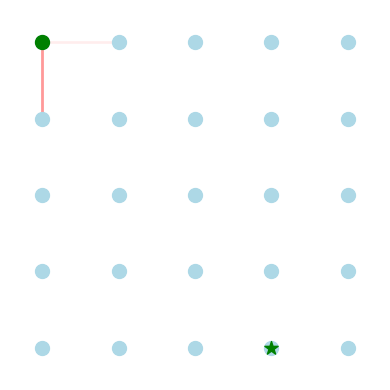

In [29]:
layer = 0
attentions = layer_attributions[layer]
attentions = clip_and_normalize(attentions)
plot_trajectory(
    states, next_states, traj['query_state'],
    attentions,
    env)

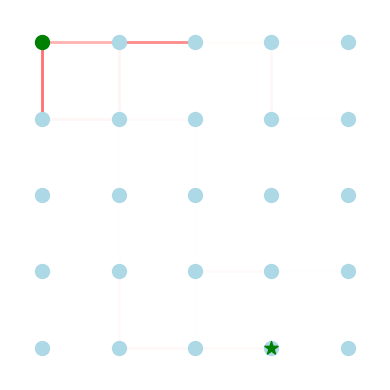

In [30]:
layer = 1
attentions = layer_attributions[layer]
attentions = clip_and_normalize(attentions)
plot_trajectory(
    states, next_states, traj['query_state'],
    attentions,
    env)

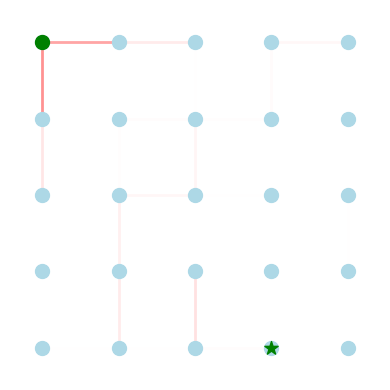

In [31]:
layer = 2
attentions = layer_attributions[layer]
attentions = clip_and_normalize(attentions)
plot_trajectory(
    states, next_states, traj['query_state'],
    attentions,
    env)

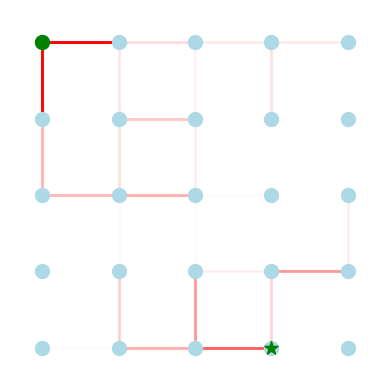

In [36]:
attentions = input_to_output_attribution
attentions = clip_and_normalize(attentions)
plot_trajectory(
    states, next_states, traj['query_state'],
    attentions,
    env,
    figname='ig_input_to_output.svg'
    )